# VARLINGAM for Time Series Causal Discovery

VARLINGAM can be used for causal discovery in time series data with contemporaneous causal connections. This algorithm can be broadly divided into two steps. First, we estimate the time lagged causal effects using vector autoregression. Second, we estimate the instantaneous causal effects by applying the LiNGAM algorithm on the residuals of the previous step, where LiNGAM exploits the non-Gaussianity of the residuals to estimate the instantaneous variables' causal order.

This algorithm makes the following assumptions: 
1. linear relationship between variables, 
2. non-Gaussianity of the error (regression residuals), 
3. no cycles among contemporaneous causal relations, and 
4. no hidden confounders. 

We do not support multi-processing for this algorithm.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import pickle as pkl
import time


In [2]:
from causalai.models.time_series.var_lingam import VARLINGAM

from causalai.data.data_generator import DataGenerator
# also importing data object, data transform object, and prior knowledge object, and the graph plotting function
from causalai.data.time_series import TimeSeriesData
from causalai.data.transforms.time_series import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall

## Load and Visualize Data

Load the dataset and visualize the ground truth causal graph. For the purpose of this example, we will use a synthetic dataset available in our repository.

In [3]:

fn = lambda x:x
coef = 0.1
sem = {
        'a': [], 
        'b': [(('a', -1), coef, fn), (('f', -2), coef, fn)], 
        'c': [(('b', 0), coef, fn), (('f', -2), coef, fn)],
        'd': [(('b', -4), coef, fn), (('b', -1), coef, fn), (('g', -1), coef, fn)],
        'e': [(('f', -1), coef, fn)], 
        'f': [],
        'g': [],
        }
T = 10000
data_array, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, noise_fn=[np.random.rand]*len(sem.keys()))
graph_gt

{'a': [],
 'b': [('a', -1), ('f', -2)],
 'c': [('b', 0), ('f', -2)],
 'd': [('b', -4), ('b', -1), ('g', -1)],
 'e': [('f', -1)],
 'f': [],
 'g': []}

Now we perform the following operations:

1. Standardize the data arrays
2. Create the data object

In [4]:


# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TimeSeriesData(data_trans, var_names=var_names)



We visualize the data and graph below:

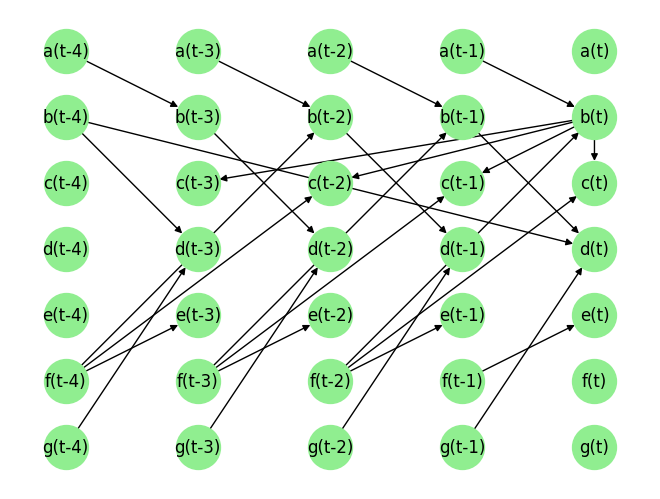

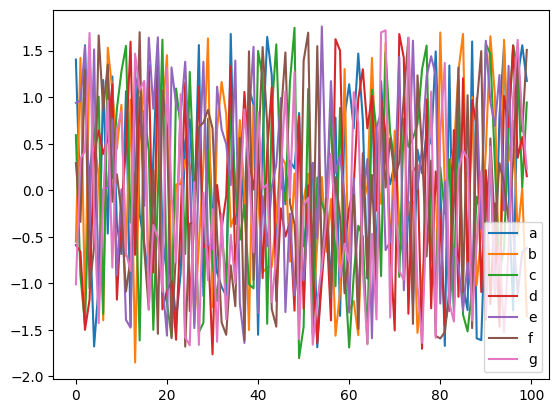

In [5]:


plot_graph(graph_gt, node_size=1000)



for i, n in enumerate(var_names):
    plt.plot(data_trans[-100:,i], label=n)
plt.legend()
plt.legend()
plt.show()

## Causal Discovery (CD)

For VARLINGAM algorithm, causal discovery can be performed for the whole graph (Full Causal Discovery). Targeted causal discovery (finding parents of a specific target variable) is not supported like some of the other algorithms in our library.

Multiprocessing is not supported in VARLINGAM.

Specifying Prior Knowledge is not supported in VARLINGAM.


### Full Causal Discovery

In [6]:

max_lag = 4
print(f'Using max_lag {max_lag}')

var_lingam = VARLINGAM(
        data=data_obj
        )


Using max_lag 4


In [7]:
tic = time.time()
result = var_lingam.run(pvalue_thres=0.03, max_lag=max_lag)
toc = time.time()
print(f'Time taken: {toc-tic:.2f}s\n')


print(f' The output graph_dict has keys: {result.keys()}')

/Users/darpit/miniconda3/envs/causal_ai_env/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
/Users/darpit/miniconda3/envs/causal_ai_env/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
/Users/darpit/miniconda3/envs/causal_ai_env/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
/Users/darpit/miniconda3/envs/causal_ai_env/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


Time taken: 0.34s

 The output graph_dict has keys: dict_keys(['a', 'b', 'c', 'd', 'e', 'f', 'g'])


The output _result_ has the variable names as its keys, and the value corresponding to each key is a dictionary with 3 keys, parents, value_dict and pvalue_dict. The first one is a list of the causal parents. The dictionary result['value_dict'] contains the strength of the link between the targeted variable and each of the candidate parents. The dictionary result['pvalue_dict'] contains the p-values of the said strength.


In [8]:
print(f'Predicted parents:')
graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')

print(f"\nGround truth parents:")  
for key in graph_gt.keys():
    print(f'{key}: {graph_gt[key]}')

precision, recall, f1_score = get_precision_recall(graph_est, graph_gt)
print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')

Predicted parents:
a: []
b: [('a', -1)]
c: [('b', 0), ('e', -1), ('b', -1)]
d: [('b', -1), ('g', -1)]
e: [('f', -1)]
f: []
g: []

Ground truth parents:
a: []
b: [('a', -1), ('f', -2)]
c: [('b', 0), ('f', -2)]
d: [('b', -4), ('b', -1), ('g', -1)]
e: [('f', -1)]
f: []
g: []
Precision 0.90, Recall: 0.81, F1 score: 0.84


The way to read this Python dictionary is that $a[t]$ has no parent. $b[t]$ has parents $a[t-1]$, and so on.